In [2]:
import pandas as pd 

from gptchem.gpt_classifier import GPTClassifier
from gptchem.tuner import Tuner
from gptchem.formatter import RegressionFormatter
from sklearn.model_selection import train_test_split

from pycm import ConfusionMatrix

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import pickle


/u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING = {
    "t5": ["q", "v"],
    "mt5": ["q", "v"],
    "bart": ["q_proj", "v_proj"],
    "gpt2": ["c_attn"],
    "bloom": ["query_key_value"],
    "blip-2": ["q", "v", "q_proj", "v_proj"],
    "opt": ["q_proj", "v_proj"],
    "gptj": ["q_proj", "v_proj"],
    "gpt_neox": ["query_key_value"],
    "gpt_neo": ["q_proj", "v_proj"],
    "bert": ["query", "value"],
    "roberta": ["query", "value"],
    "xlm-roberta": ["query", "value"],
    "electra": ["query", "value"],
    "deberta-v2": ["query_proj", "value_proj"],
    "deberta": ["in_proj"],
    "layoutlm": ["query", "value"],
    "llama": ["q_proj", "v_proj"],
    "chatglm": ["query_key_value"],
}

In [7]:
import sys
from typing import List
import torch
import transformers

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)
from datasets import Dataset

from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, EarlyStoppingCallback
import os
print(torch.cuda.device_count())


4


In [8]:
#get the data
def get_data():
    with open("qm9_key_smiles_0_val_u0_atom_b3lyp.pickle", 'rb') as pickle_file:
        pickled_data=pickle.load(pickle_file)
    raw_data = pd.DataFrame(list(pickled_data.items()), columns=["SMILES", "B3LYP atomization energy in kcal/mol"])
    formatter = RegressionFormatter(representation_column='SMILES',
        label_column='B3LYP atomization energy in kcal/mol',
        property_name='atomization energy in kcal/mol',
        num_digits=4
        )
    data = formatter.format_many(raw_data).drop(columns=["label","representation"], axis=1)
    train_size=round(0.8*len(data))
    val_size=round((len(data)-train_size)/2)
    test_size=len(data)-train_size-val_size
    df_trainval, df_test = train_test_split(data, test_size=val_size, train_size=train_size, random_state=42)
    df_train, df_val = train_test_split(df_trainval,test_size=test_size, shuffle=True)
    return df_train, df_val, df_test

In [19]:
def train(
    #dataframes
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    # model/data params
    base_model: str = "gpt2",  # the only required argument
    data_path: str = "qm9_key_smiles_0_val_u0_atom_b3lyp.pickle",
    output_dir: str = "outputs",
    # training hyperparams
    batch_size: int = 1024,
    micro_batch_size: int = 64,
    num_epochs: int = 3,
    learning_rate: float = 3e-4,
    cutoff_len: int = 256,
    # lora hyperparams
    lora_r: int = 8,
    lora_alpha: int = 16,
    lora_dropout: float = 0.05,
    lora_target_modules: List[str] = [""],
    # llm hyperparams
    train_on_inputs: bool = True,  # if False, masks out inputs in loss
    group_by_length: bool = False,  # faster, but produces an odd training loss curve
    resume_from_checkpoint: str = None,  # either training checkpoint or final adapter
    prompt_template_name: str = "chemgpt",  # The prompt template to use, will default to alpaca.
):
    
    lora_target_modules = TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING[base_model]
    if int(os.environ.get("LOCAL_RANK", 0)) == 0:
        print(
            f"Training LoRA model with params:\n"
            f"base_model: {base_model}\n"
            f"data_path: {data_path}\n"
            f"output_dir: {output_dir}\n"
            f"batch_size: {batch_size}\n"
            f"micro_batch_size: {micro_batch_size}\n"
            f"num_epochs: {num_epochs}\n"
            f"learning_rate: {learning_rate}\n"
            f"cutoff_len: {cutoff_len}\n"
            f"lora_r: {lora_r}\n"
            f"lora_alpha: {lora_alpha}\n"
            f"lora_dropout: {lora_dropout}\n"
            f"lora_target_modules: {lora_target_modules}\n"
            f"train_on_inputs: {train_on_inputs}\n"
            f"group_by_length: {group_by_length}\n"
            f"resume_from_checkpoint: {resume_from_checkpoint or False}\n"
            f"prompt template: {prompt_template_name}\n"
        )
    assert (
        base_model
    ), "Please specify a --base_model, e.g. --base_model='gpt2'"
    gradient_accumulation_steps = batch_size // micro_batch_size

    device_map = "sequential"
    world_size = int(os.environ.get("WORLD_SIZE", 1))
    #ddp = world_size != 1
    ddp = False
    if ddp:
        device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
        gradient_accumulation_steps = gradient_accumulation_steps // world_size
    
    #set up the model and tokenizer    
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    # might not be optimal, just trying to run the code
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        base_model, 
        load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map='sequential',
    )    
    def tokenize(prompt):
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=cutoff_len,
            padding=True,
            return_tensors=None,
        )
        return result
    
    def tokenize_prompt(data_point):
        full_prompt = data_point["prompt"]+data_point["completion"]
        tokenized_full_prompt = tokenize(full_prompt)
        return tokenized_full_prompt

    model = prepare_model_for_int8_training(model)

    config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=lora_target_modules,
        lora_dropout=lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(model, config)

    train_data = Dataset.from_pandas(df_train).shuffle().map(tokenize_prompt)
    val_data = Dataset.from_pandas(df_val).shuffle().map(tokenize_prompt)
    test_data = Dataset.from_pandas(df_test).shuffle().map(tokenize_prompt)
    
    if resume_from_checkpoint:
        # Check the available weights and load them
        checkpoint_name = os.path.join(
            resume_from_checkpoint, "pytorch_model.bin"
        )  # Full checkpoint
        if not os.path.exists(checkpoint_name):
            checkpoint_name = os.path.join(
                resume_from_checkpoint, "adapter_model.bin"
            )  # only LoRA model - LoRA config above has to fit
            resume_from_checkpoint = (
                False  # So the trainer won't try loading its state
            )
        # The two files above have a different name depending on how they were saved, but are actually the same.
        if os.path.exists(checkpoint_name):
            print(f"Restarting from {checkpoint_name}")
            adapters_weights = torch.load(checkpoint_name)
            model = set_peft_model_state_dict(model, adapters_weights)
        else:
            print(f"Checkpoint {checkpoint_name} not found")

    model.print_trainable_parameters()  # Be more transparent about the % of trainable params.
    
    if not ddp and torch.cuda.device_count() > 1:
        # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
        model.is_parallelizable = True
        model.model_parallel = True
   
    trainer = transformers.Trainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=micro_batch_size,
            gradient_accumulation_steps=gradient_accumulation_steps,
            warmup_steps=10,
            num_train_epochs=num_epochs,
            learning_rate=learning_rate,
            fp16=True,
            logging_steps=4,
            optim="adamw_torch",
            evaluation_strategy="steps",
            save_strategy="steps",
            eval_steps=4,
            save_steps=4,
            output_dir=output_dir,
            save_total_limit=3,
            metric_for_best_model = 'eval_loss',
            load_best_model_at_end=True,
            ddp_find_unused_parameters=False if ddp else None,
            group_by_length=group_by_length,
        ),
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )
    model.config.use_cache = False

    old_state_dict = model.state_dict
    print(old_state_dict)
    print(model.state_dict)
    model.state_dict = (
        lambda self, *_, **__: get_peft_model_state_dict(
            self, old_state_dict()
        )
    ).__get__(model, type(model))
    
    
    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    trainer.train(resume_from_checkpoint=resume_from_checkpoint)

    model.save_pretrained(output_dir)

    print(
        "\n If there's a warning about missing keys above, please disregard :)"
    )

In [43]:
import os
import sys

import torch
from peft import PeftModel
from transformers import GenerationConfig
#from utils.callbacks import Iteratorize, Stream

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu" 
    
def generate(
    df_test: pd.DataFrame,
    load_8bit: bool = False,
    base_model: str = "gpt2",
    lora_weights: str = "outputs",
    prompt_template: str = "",
    cutoff_len: int = 256,
):
    #set up the model and tokenizer    
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    # might not be optimal, just trying to run the code
    tokenizer.pad_token = tokenizer.eos_token
    
    def tokenize(prompt):
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=cutoff_len,
            padding=True,
            return_tensors="pt",
        )
        return result

    model= AutoModelForCausalLM.from_pretrained(
        base_model, 
        load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map='sequential',
    )    
    model = PeftModel.from_pretrained(
        model,
        lora_weights,
        torch_dtype=torch.float16,
    )

    if not load_8bit:
        model.half()  # seems to fix bugs for some users.

    model.eval()
    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    def evaluate(
        prompt,
        temperature=0,
        top_p=0.75,
        top_k=40,
        num_beams=4,
        max_new_tokens=128,
        stream_output=False,
        **kwargs,
    ):

        inputs = tokenize(prompt)
        input_ids = inputs["input_ids"].to(device)
        generation_config = GenerationConfig(
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            num_beams=num_beams,
            **kwargs,
        )

        generate_params = {
            "input_ids": input_ids,
            "generation_config": generation_config,
            "return_dict_in_generate": True,
            "output_scores": True,
            "max_new_tokens": max_new_tokens,
        }

        # Without streaming
        with torch.no_grad():
            generation_output = model.generate(
                input_ids=input_ids,
                generation_config=generation_config,
                return_dict_in_generate=True,
                output_scores=True,
                max_new_tokens=max_new_tokens,
            )
        s = generation_output.sequences[0]
        output = tokenizer.decode(s)
        #print(output)
        return output

    df_test["model_out"] = df_test["prompt"].map(lambda x: evaluate(x))
    df_test["energy_out"] = df_test["model_out"].map(lambda x: float(x.replace('###','@@@').split('@@@')[1]))
    df_test["energy_true"] = df_test["completion"].map(lambda x: float(x.split('@@@')[0]))
    return(df_test)

In [45]:
if __name__ == "__main__":
    df_train, df_val, df_test = get_data()
    #train(df_train, df_val, base_model="gpt2")
    outs=generate(df_test.head(25), base_model="gpt2")

/tmp/ipykernel_1599169/3480655279.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["model_out"] = df_test["prompt"].map(lambda x: evaluate(x))
/tmp/ipykernel_1599169/3480655279.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["energy_out"] = df_test["model_out"].map(lambda x: float(x.replace('###','@@@').split('@@@')[1]))
/tmp/ipykernel_1599169/3480655279.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [46]:
outs

,prompt,completion,model_out,energy_out,energy_true
74606,What is the atomization energy in kcal/mol of ...,-2071.9989@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-2071.9989
56992,What is the atomization energy in kcal/mol of ...,-1890.364@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1890.3640
16367,What is the atomization energy in kcal/mol of ...,-1361.6393@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1361.6393
12238,What is the atomization energy in kcal/mol of ...,-1466.7489@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1466.7489
42893,What is the atomization energy in kcal/mol of ...,-1591.6076@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1591.6076
13203,What is the atomization energy in kcal/mol of ...,-1405.7739@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1405.7739
82846,What is the atomization energy in kcal/mol of ...,-1841.7596@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1841.7596
25217,What is the atomization energy in kcal/mol of ...,-1599.1101@@@,What is the atomization energy in kcal/mol of ...,-1858.906,-1599.1101
47472,What is the atomization energy in kcal/mol of ...,-1743.1485@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1743.1485
116647,What is the atomization energy in kcal/mol of ...,-1798.0185@@@,What is the atomization energy in kcal/mol of ...,-1853.906,-1798.0185


# Regression 

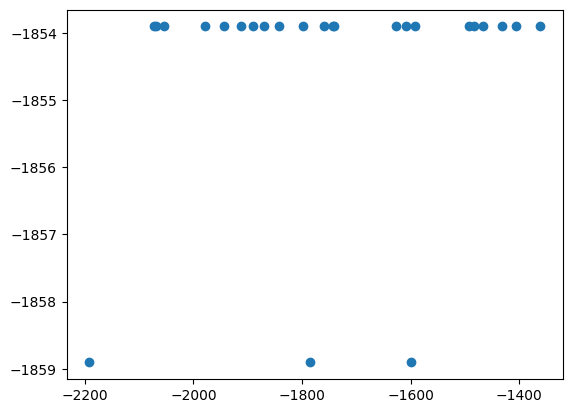

In [49]:
plt.scatter(outs['energy_true'], outs['energy_out'])

In [48]:
pearsonr(outs['energy_true'], outs['energy_out'])

PearsonRResult(statistic=0.17585074724844418, pvalue=0.4004486010967057)